In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Data Wrangling
# Convert timestamp to datetime
train_df['datetime'] = pd.to_datetime(train_df['timestamp'], unit='s')
test_df['datetime'] = pd.to_datetime(test_df['timestamp'], unit='s')

In [4]:
# Extract time-based features
for df in [train_df, test_df]:
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month

In [5]:
# Calculate the difference between actual and predicted values
train_df['diff'] = train_df['value'] - train_df['predicted']
test_df['diff'] = test_df['value'] - test_df['predicted']

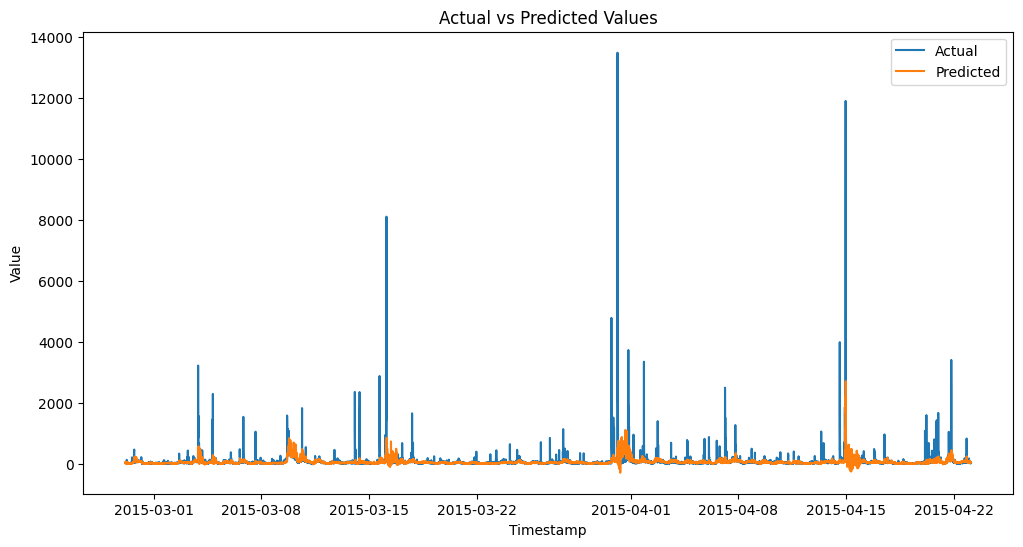

In [6]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(train_df['datetime'], train_df['value'], label='Actual')
plt.plot(train_df['datetime'], train_df['predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
# Prepare features for model training
features = ['hour', 'day_of_week', 'month', 'value', 'predicted', 'diff']
X = train_df[features]
y = train_df['is_anomaly']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Make predictions on validation set
val_predictions = rf_model.predict(X_val_scaled)

In [11]:
# Calculate F1 score
f1 = f1_score(y_val, val_predictions)
print(f"Validation F1 Score: {f1}")

Validation F1 Score: 0.7070707070707071


In [12]:
# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

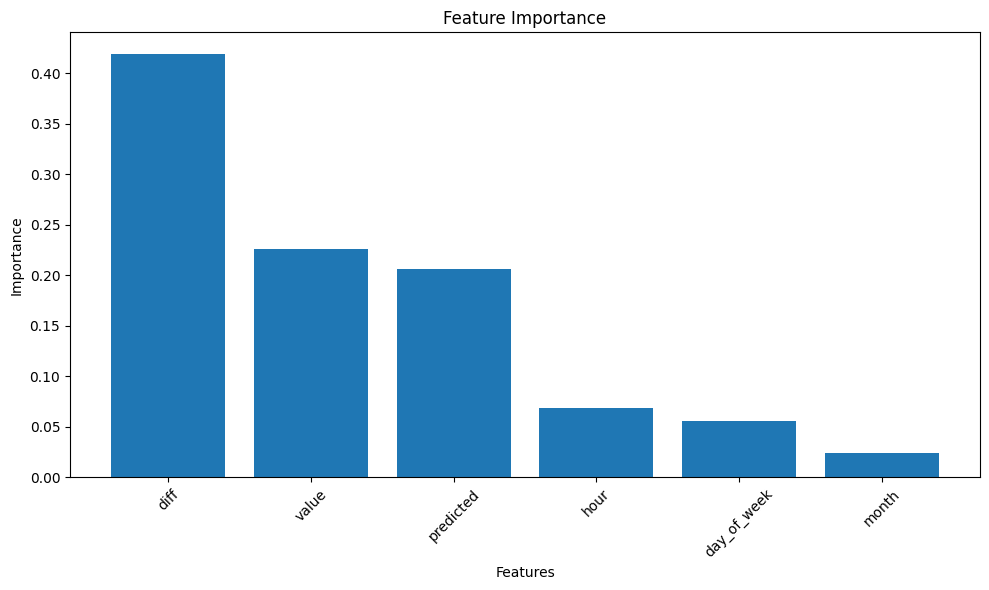

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Prepare test data
X_test = test_df[features]
X_test_scaled = scaler.transform(X_test)

# Make predictions on test data
test_predictions = rf_model.predict(X_test_scaled)

In [15]:
# Create submission DataFrame
submission = pd.DataFrame({
    'timestamp': test_df['timestamp'],
    'is_anomaly': test_predictions
})

# Export to CSV
submission.to_csv('submission.csv', index=False)

In [16]:
# Calculate additional metrics
submission['datetime'] = pd.to_datetime(submission['timestamp'], unit='s')
submission['hour'] = submission['datetime'].dt.hour
submission['day_of_week'] = submission['datetime'].dt.dayofweek
submission['month'] = submission['datetime'].dt.month

# Calculate the percentage of anomalies
anomaly_percentage = (submission['is_anomaly'].sum() / len(submission)) * 100

# Calculate anomalies by hour, day of week, and month
anomalies_by_hour = submission.groupby('hour')['is_anomaly'].mean() * 100
anomalies_by_day = submission.groupby('day_of_week')['is_anomaly'].mean() * 100
anomalies_by_month = submission.groupby('month')['is_anomaly'].mean() * 100

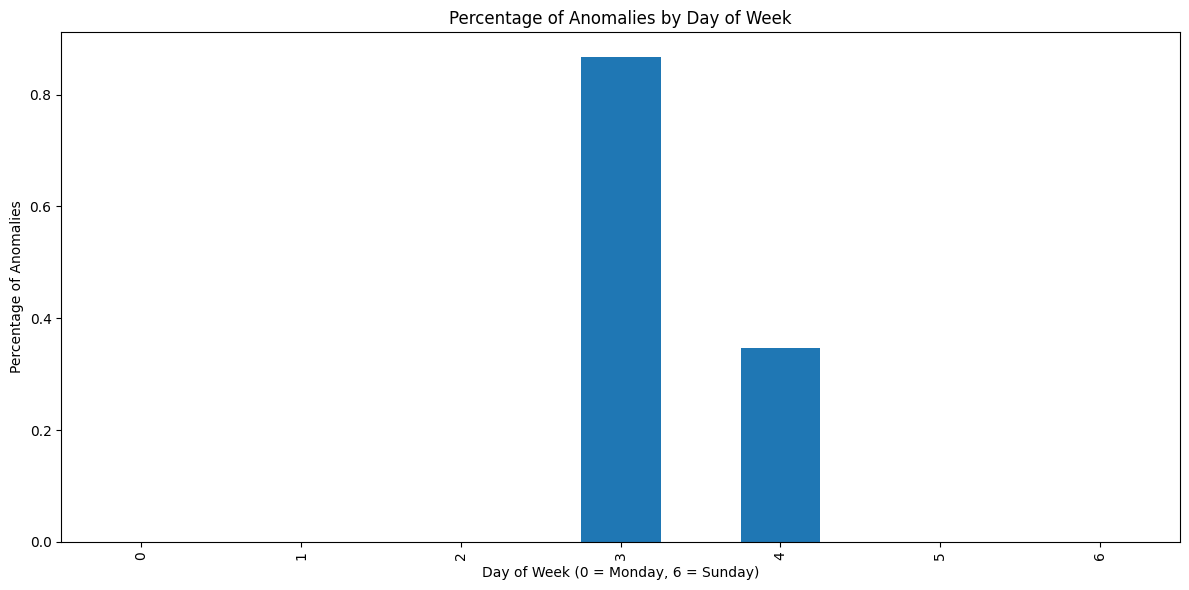

In [18]:
# Visualize anomalies by day of week
plt.figure(figsize=(12, 6))
anomalies_by_day.plot(kind='bar')
plt.title('Percentage of Anomalies by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Percentage of Anomalies')
plt.tight_layout()
plt.show()

In [20]:
# Describe the submission DataFrame
print(submission.describe())


          timestamp             datetime         hour  day_of_week   month
count  3.960000e+03                 3960  3960.000000  3960.000000  3960.0
mean   1.396926e+09  2014-04-08 02:57:30    11.663636     3.036364     4.0
min    1.396332e+09  2014-04-01 06:00:00     0.000000     0.000000     4.0
25%    1.396629e+09  2014-04-04 16:28:45     6.000000     1.000000     4.0
50%    1.396926e+09  2014-04-08 02:57:30    12.000000     3.000000     4.0
75%    1.397223e+09  2014-04-11 13:26:15    18.000000     5.000000     4.0
max    1.397520e+09  2014-04-14 23:55:00    23.000000     6.000000     4.0
std    3.429894e+05                  NaN     6.873665     1.999922     0.0


In [21]:
# Print summary statistics
print(f"\nTotal number of data points: {len(submission)}")
print(f"Total number of anomalies detected: {submission['is_anomaly'].sum()}")
print(f"Percentage of anomalies: {anomaly_percentage:.2f}%")
print("\nTop 3 hours with highest anomaly percentage:")
print(anomalies_by_hour.nlargest(3))
print("\nTop 3 days of week with highest anomaly percentage:")
print(anomalies_by_day.nlargest(3))
print("\nTop 3 months with highest anomaly percentage:")
print(anomalies_by_month.nlargest(3))


Total number of data points: 3960
Total number of anomalies detected: 7
Percentage of anomalies: 0.18%

Top 3 hours with highest anomaly percentage:
hour
9    4.166667
0    0.000000
1    0.000000
Name: is_anomaly, dtype: float64

Top 3 days of week with highest anomaly percentage:
day_of_week
3    0.868056
4    0.347222
0    0.000000
Name: is_anomaly, dtype: float64

Top 3 months with highest anomaly percentage:
month
4    0.176768
Name: is_anomaly, dtype: float64
